Title: Numerical Awareness Convergence Lab
Subtitle: equality traps · atol/rtol · scale-relative stopping · norm-based convergence

Goal:
Show why == breaks ML decisions and how np.isclose(atol, rtol) + scale-relative criteria stabilizes stopping logic.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=18, suppress=False)

ASSET_DIR = "../../proofs/02-math/assets/numerical-awareness"

Part A — Equality trap (0.1 + 0.2)

In [2]:
a= 0.1 + 0.2
b= 0.3

print("a:", a)
print("b:", b)
print("a==b ?", a == b)

print("abs diff:", abs(a-b))
print ("isclose default:", np.isclose(a, b))
print("isclose tight", np.isclose(a, b, atol=1e-12, rtol=1e-12))
print("isclose too strict:", np.isclose(a, b, atol=0.0, rtol=0.0))


a: 0.30000000000000004
b: 0.3
a==b ? False
abs diff: 5.551115123125783e-17
isclose default: True
isclose tight True
isclose too strict: False


Part B — atol vs rtol intuition (same delta, different scale)

We compare two losses with the same absolute improvement but different magnitudes.

In [6]:
cases = [
    ("large", 1e6, 0.1),
    ("small", 1e-3, 0.1),
]

for name, loss, delta in cases:
    rel = delta / (abs(loss) + 1e-30)
    print(f"{name:>5} | loss={loss:.3e} | delta={delta:.3e} | rel={rel:.3e}")


large | loss=1.000e+06 | delta=1.000e-01 | rel=1.000e-07
small | loss=1.000e-03 | delta=1.000e-01 | rel=1.000e+02


Part C — Convergence check: absolute vs relative stopping

We simulate an optimization curve and compare:

Stop by absolute delta (delta < atol)

Stop by relative delta (delta/loss < rtol)

Stop by np.isclose(loss_t, loss_{t-1}) with both tolerances

In [11]:
rng= np.random.default_rng(7)

T=80
loss0=1e6
decay=0.92

loss = np.zeros(T, dtype=np.float64)
loss[0] = loss0

for t in range(1, T):
    noise=rng.normal(loc=0.0, scale=0.2)
    loss[t] = loss[t-1] * decay + noise

delta = loss[:-1] - loss[1:]
rel_delta = delta / (np.abs(loss[:-1]) + 1e-30)

In [12]:
ATOL= 1e-3
RTOL= 1e-6

abs_stop = np.where(delta<ATOL)[0]
rel_stop = np.where(rel_delta<RTOL)[0]
isclose_stop = np.where(np.isclose(loss[1:], loss[:-1], atol=ATOL, rtol=RTOL))[0]

print("first abs_stop index:", int(abs_stop[0]) if len(abs_stop) else None)
print("first rel_stop index:", int(rel_stop[0]) if len(rel_stop) else None)
print("first isclose_stop index:", int(isclose_stop[0]) if len(isclose_stop) else None)

print("same deldas (t, delta, rel):")
for t in[0,5,10, 20, 40, 60]:
    if t < len(delta):
        print(t, delta[t],rel_delta[t])

first abs_stop index: None
first rel_stop index: None
first isclose_stop index: None
same deldas (t, delta, rel):
0 79999.99975396937 0.07999999975396938
5 52726.69982475543 0.08000030091783875
10 34750.95530985901 0.07999977446805012
20 15095.759306002205 0.08000195210317394
40 2848.3213653542443 0.07999937948975677
60 537.4591983582895 0.07999395308126887


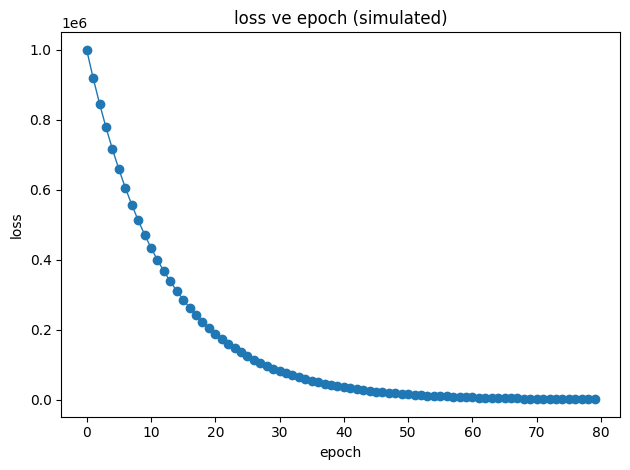

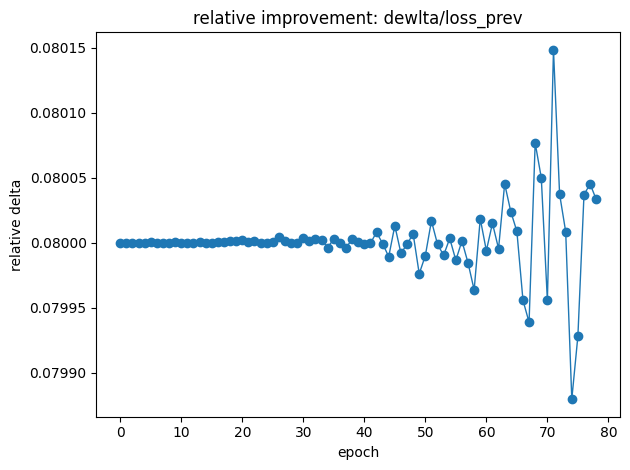

In [14]:
plt.figure()
plt.plot(loss, marker="o", linewidth=1)
plt.title("loss ve epoch (simulated)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.tight_layout()

plt.figure()
plt.plot(rel_delta, marker="o", linewidth=1)
plt.title("relative improvement: dewlta/loss_prev")
plt.xlabel("epoch")
plt.ylabel("relative delta")
plt.tight_layout()

Part D — Norm-based convergence (gradient / parameter scale)

We show why grad_norm < const is brittle and why grad_norm / param_norm < rtol is scale-aware.

In [15]:
param_norms = np.array([1e-3, 1.0, 1e3, 1e6], dtype=np.float64)
grad_norm = np.float64(1.0)
rtol= np.float64(1e-6)

print("grad_norm fixed=", grad_norm)
for p in param_norms:
    ratio=grad_norm / (p + 1e-30)
    decision= ratio < rtol
    print(f"param_norm={p:>10.3e} | ratio={ratio:>10.3e} | stop?{decision}")

grad_norm fixed= 1.0
param_norm= 1.000e-03 | ratio= 1.000e+03 | stop?False
param_norm= 1.000e+00 | ratio= 1.000e+00 | stop?False
param_norm= 1.000e+03 | ratio= 1.000e-03 | stop?False
param_norm= 1.000e+06 | ratio= 1.000e-06 | stop?False


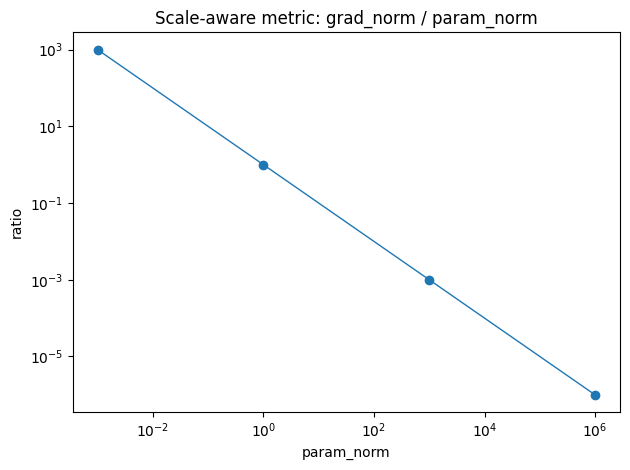

In [18]:
ratios = grad_norm / (param_norms + 1e-30)

plt.figure()
plt.plot(param_norms, ratios, marker="o", linewidth=1)
plt.title("Scale-aware metric: grad_norm / param_norm")
plt.xlabel("param_norm")
plt.ylabel("ratio")
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()


Save assets (PNG) for proofs

This will create:

equality_isclose.png

scale_relative_delta.png

norm_based_stop.png

saved assets to: ../../proofs/02-math/assets/numerical-awareness


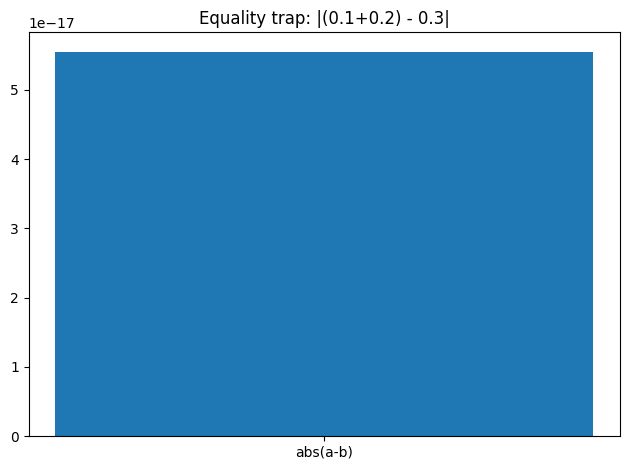

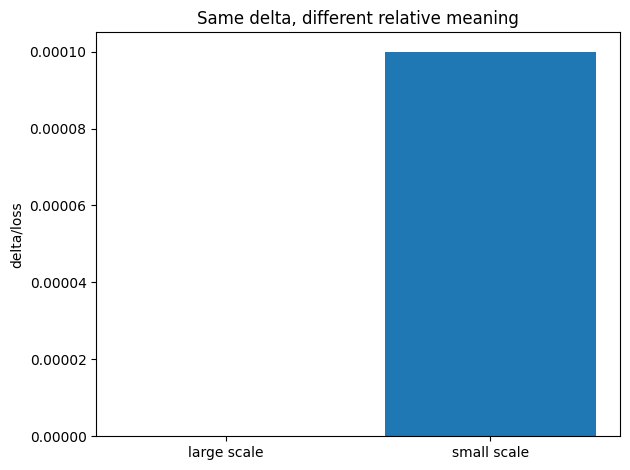

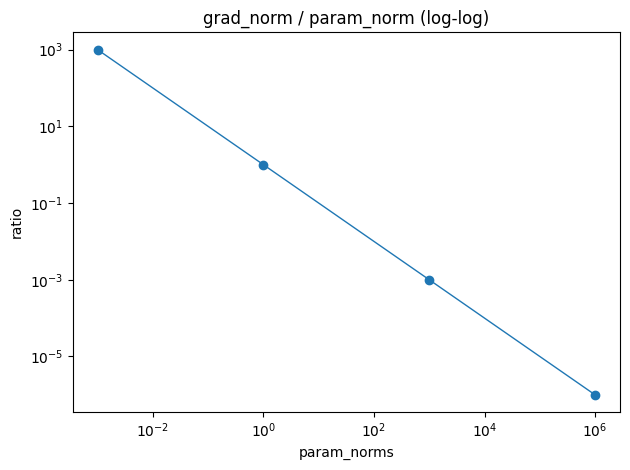

In [20]:
import os
os.makedirs(ASSET_DIR, exist_ok=True)

a=0.1 + 0.2
b= 0.3
diff=abs(a-b)

plt.figure()
plt.bar(["abs(a-b)"], [diff])
plt.title("Equality trap: |(0.1+0.2) - 0.3|")
plt.tight_layout()
plt.savefig(os.path.join(ASSET_DIR, "equality_isclose.png"), dpi=180)


loss_large, delta_large= 1e6,0.1
loss_small, delta_small= 1e3,0.1

rels=[delta_large/loss_large, delta_small/loss_small]
plt.figure()
plt.bar(["large scale", "small scale"], rels)
plt.title("Same delta, different relative meaning")
plt.ylabel("delta/loss")
plt.tight_layout()
plt.savefig(os.path.join(ASSET_DIR, "scale_relative_delta.png"), dpi=180)

param_norms=np.array([1e-3, 1.0, 1e3, 1e6], dtype=np.float64)
grad_norm=1.0
ratios=grad_norm / (param_norms + 1e-30)

plt.figure()
plt.plot(param_norms, ratios, marker="o", linewidth=1)
plt.title("grad_norm / param_norm (log-log)")
plt.xlabel("param_norms")
plt.ylabel("ratio")
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.savefig(os.path.join(ASSET_DIR, "norm_based_stop.png"), dpi=180)

print("saved assets to:", ASSET_DIR)